The analysis of the EDA performed revealed some interesting things. After performing my inferential analysis, it was found that there was a statistically significant difference in means between DNS packets generated between the honeypot and server for both benign and malicious websites. It was also found that TCP packets exchangeds for different malicious website servers, such as Apache, Nginx, and "other", were found to have statistically significant difference as we rejected our null hypothesis stating that the means were equal between all groups. I expect these features, 'tcp_conversion_exchange', 'dns_query_times' to have some importance for our modeling. We will be using the 'type' column for predictions. 1 represents a malicious website and 0 represents a benign website. Some preprocessing techniques I believe I will need to employ off the bat will be an encoding technique to encode a few features for machine learning. I don't think encoding that date columns is a good idea because of how unique each of them are. They would produce thousands of extra features, which would potentially lead to "curse of dimensionality", and there is simply not enough data for any meaningful learning. Let's get started!

In [39]:
# Standard DS imports
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Machine learning imports
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import train_test_split, StratifiedKFold, RepeatedKFold, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, explained_variance_score, r2_score, mean_absolute_error
from sklearn.feature_selection import RFE
from imblearn.over_sampling import SMOTE

# Machine Learning Algorithms
from sklearn.impute import KNNImputer
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, RandomForestRegressor, ExtraTreesRegressor

#data balancing
import imblearn
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

For this notebook, I am going to bring in all the cleaning I did in my other notebook, but I will further preprocess the data and clean up columns for machine learning!

In [4]:
# Call in dataset and inspect the head.
df = pd.read_csv("dataset.csv")

In [5]:
#Going to create a copy of the df to work with.
df_copy = df.copy()

In [6]:
#Make all columns lowercase
df_copy.columns = df_copy.columns.str.lower()

In [8]:
#Clean up the 'charset' column: replace the dashes with spaces and make it Title case
df_copy['charset'] = df_copy['charset'].str.replace('-', ' ')
df_copy['charset'] = df_copy['charset'].str.title()

In [9]:
#Going to perform null value imputation with KNN imputation method.

#Encode only the known values.
le = LabelEncoder()
df_copy['charset_encoded'] = df_copy['charset']
df_copy.loc[df_copy['charset'].notnull(), 'charset_encoded'] = le.fit_transform(df_copy['charset'].dropna())

#Apply KNN imputation on the encoded column.
imputer = KNNImputer(n_neighbors=3)
df_copy['charset_encoded'] = imputer.fit_transform(df_copy[['charset_encoded']])

#Inverse transform the encoded data back to the original categories.
df_copy['charset_imputed'] = df_copy['charset_encoded'].round().astype(int)
df_copy['charset_imputed'] = le.inverse_transform(df_copy['charset_imputed'])

#Compare the original and imputed columns to verify our imputation has succeeded.
imputed_values = df_copy[df_copy['charset'].isnull()]

print(imputed_values[['charset', 'charset_imputed']])

     charset charset_imputed
35       NaN        Us Ascii
81       NaN        Us Ascii
125      NaN        Us Ascii
159      NaN        Us Ascii
952      NaN        Us Ascii
977      NaN        Us Ascii
1069     NaN        Us Ascii


In [10]:
#Dropping as no longer needed.
df_copy = df_copy.drop(columns=["charset_encoded", "charset"])

In [11]:
#Fill in nulls with unknown.
df_copy['server'].fillna("Unknown", inplace=True)

In [12]:
#Clean up the 'charset' column: replace the dashes with spaces and make it Title case
df_copy['server'] = df_copy['server'].str.lower()

In [13]:
#Grouping values with the least count into one bin "Other" to reduce number of unique values
series = pd.value_counts(df_copy.server)
mask = (series/series.sum() * 100).lt(1)
df_copy['server'] = np.where(df_copy['server'].isin(series[mask].index),'other',df_copy['server'])

In [14]:
 # Further bucketing and cleaning up the server column.

def standardize_server(server_string):
    if 'apache' in server_string:
        return 'apache'
    if 'nginx' in server_string:
        return 'nginx'
    if 'microsoft' in server_string:
        return 'microsoft-IIS'

    return server_string

#Applying function.
df_copy['standardized_server'] = df_copy['server'].apply(standardize_server)
df_copy['standardized_server'] = df_copy['standardized_server'].str.replace('-', ' ')

print(df_copy[['server', 'standardized_server']])

                     server standardized_server
0                     nginx               nginx
1                     other               other
2     microsoft-httpapi/2.0       microsoft IIS
3                     nginx               nginx
4                   unknown             unknown
...                     ...                 ...
1776                 apache              apache
1777                 apache              apache
1778                  other               other
1779       cloudflare-nginx               nginx
1780                  other               other

[1781 rows x 2 columns]


In [15]:
df_copy['content_length'] = df_copy['content_length'].interpolate()

In [16]:
#Function to replace the strange values in the column.
def replace(x):
    if x == "[u'GB'; u'UK']"or x=="United Kingdom" or x=="UK":
        return "GB"
    elif x == "Cyprus":
        return "CY"
    elif x == "us":
        return "US"
    elif x == "ru":
        return "RU"
    elif x == "se":
        return "SE"
    else:
        return x
    
df_copy["whois_country"] = list(map(lambda x: replace(x), df_copy["whois_country"]))

In [17]:
#Filling the NA as 'other' category.
df_copy['whois_country'].fillna("Other", inplace=True)

In [18]:
#Cleaning up data and nulls.
def replace_state(x):
    if x == "California"or x=="CALIFORNIA":
        return "CA"
    elif x == "Arizona":
        return "AZ"
    elif x == "New York" or x=="NEW YORK":
        return "NY"
    elif x == "Ohio":
        return "OH"
    elif x == "Utah":
        return "UT"
    elif x == "None":
        return "NA"
    elif x == "Texas":
        return "TX"
    elif x == "Washington":
        return "WA"
    elif x == "va":
        return "VA"
    elif x == "Illinois" or x=="il":
        return "IL"
    elif x == "District of Columbia" or x=="DC" or x=="Maryland":
        return "MD"
    elif x == "New Jersey":
        return "NJ"
    elif x == "Maine" or x=="MAINE":
        return "ME"
    elif x == "Quebec" or x=="QUEBEC" or x=="qc" or x=="quebec":
        return "QC"
    elif x == "Missouri":
        return "MO"
    elif x == "Nevada":
        return "NV"
    elif x == "WC1N" or x=="Greater London" or x=="UK" or x=="WEST MIDLANDS" or x=="worcs" or x=="Peterborough" or x=="London" or x=="HANTS" or x=="MIDDLESEX":
        return "England"
    elif x == "Pennsylvania":
        return "PA"
    elif x == "Florida" or x=="FLORIDA":
        return "FL"
    elif x == "PANAMA":
        return "Panama"
    else:
        return x
    
df_copy["whois_statepro"] = list(map(lambda x: replace_state(x), df_copy["whois_statepro"]))

In [19]:
#Grouping values with the least count into one bin "Other" to reduce number of unique values
counts = df_copy['whois_statepro'].value_counts()
df_copy['whois_statepro'] = np.where(df_copy['whois_statepro'].isin(counts[counts < 15].index),'Other',df_copy['whois_statepro'])

In [20]:
#Fill null's with "Other".
df_copy['whois_statepro'].fillna("Other", inplace=True)

In [21]:
#Going to look at the dates now and clean up the format on those.

#Make function to clean up data column.
def date_cleaner(datetime_str):
    if datetime_str in [np.nan, "b", "0", "None"]:  # these are the missing values and a random b thrown in the mix.
        return np.nan
    
    if "T" in datetime_str:
        split_datetime = datetime_str.split("T")
    else:
        split_datetime = datetime_str.split()
    
    date = split_datetime[0]
    date_with_slash = date.replace("-", "/")
    
    if date_with_slash == "2002/03/20":  # only one instance of this.
        date_with_slash = "20/03/2002"
    return date_with_slash

In [22]:
#Going to apply the cleaner format to both regdate and updated date columns
df_copy.whois_regdate = df_copy.whois_regdate.apply(date_cleaner)
df_copy["whois_regdate"] = pd.to_datetime(df_copy.whois_regdate, format="%d/%m/%Y", errors="coerce")

#Update the updated_date column
df_copy.whois_updated_date = df_copy.whois_updated_date.apply(date_cleaner)
df_copy["whois_updated_date"] = pd.to_datetime(df_copy.whois_updated_date, format="%d/%m/%Y", errors="coerce")

#Filling null values with the median. The reason being is it is impossible to know what these dates could be. The median offers the most common date which could help with our analysis.
df_copy["whois_regdate"].fillna(df_copy["whois_regdate"].median(), inplace=True)
df_copy["whois_updated_date"].fillna(df_copy["whois_updated_date"].median(), inplace=True)

In [23]:
#I will interpolate the dns query column. It's one value, so filling in the null value with a linear approach should work.
df_copy['dns_query_times'] = df_copy['dns_query_times'].interpolate()

In [24]:
#Change column to int type for cleaner clarity.
df_copy['dns_query_times'] = df_copy['dns_query_times'].astype(int) 

In [25]:
#Drop the server column since we have it standardized and ready to go.
df_copy = df_copy.drop(columns=["server"])

In [26]:
df_copy

,url,url_length,number_special_characters,content_length,whois_country,whois_statepro,whois_regdate,whois_updated_date,tcp_conversation_exchange,dist_remote_tcp_port,...,app_bytes,source_app_packets,remote_app_packets,source_app_bytes,remote_app_bytes,app_packets,dns_query_times,type,charset_imputed,standardized_server
0,M0_109,16,7,263.0,Other,Other,2015-10-10,2016-08-23,7,0,...,700,9,10,1153,832,9,2,1,Iso 8859 1,nginx
1,B0_2314,16,6,15087.0,Other,Other,2001-01-16,2016-08-23,17,7,...,1230,17,19,1265,1230,17,0,0,Utf 8,other
2,B0_911,16,6,324.0,Other,Other,2001-01-16,2016-08-23,0,0,...,0,0,0,0,0,0,0,0,Us Ascii,microsoft IIS
3,B0_113,17,6,162.0,US,Other,1997-10-07,2013-09-12,31,22,...,3812,39,37,18784,4380,39,8,0,Iso 8859 1,nginx
4,B0_403,17,6,124140.0,US,TX,1996-05-12,2017-04-11,57,2,...,4278,61,62,129889,4586,61,4,0,Utf 8,unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1776,M4_48,194,16,6897.0,ES,Barcelona,2008-09-17,2016-09-02,0,0,...,0,0,3,186,0,0,0,1,Utf 8,apache
1777,M4_41,198,17,7900.5,ES,Barcelona,2008-09-17,2016-09-02,0,0,...,0,0,2,124,0,0,0,1,Utf 8,apache
1778,B0_162,201,34,8904.0,US,FL,1999-02-15,2015-07-15,83,2,...,6631,87,89,132181,6945,87,4,0,Utf 8,other
1779,B0_1152,234,34,16669.5,US,CA,1998-04-01,2016-12-09,0,0,...,0,0,0,0,0,0,0,0,Iso 8859 1,nginx


### The URL is encoded in a unique way and they are all unique urls in the data set. It won't be helpful for us in our analysis by revealing any sort of importance or prediction, therefore I will drop that column. I will try encoding certain categorical columns.

In [57]:
preprocess_df = df_copy.copy()

In [58]:
preprocess_df.drop(columns=["url", "whois_regdate", "whois_updated_date"], inplace=True)


In [59]:
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')

In [60]:
columns_to_encode = ['whois_country', 'whois_statepro', 'charset_imputed', 'standardized_server']


In [61]:
encoded_data = encoder.fit_transform(preprocess_df[columns_to_encode])

In [62]:
feature_names = encoder.get_feature_names_out(columns_to_encode)

In [63]:
encoded_df = pd.DataFrame(encoded_data, columns=feature_names)
encoded_df

,whois_country_AE,whois_country_AT,whois_country_AU,whois_country_BE,whois_country_BR,whois_country_BS,whois_country_BY,whois_country_CA,whois_country_CH,whois_country_CN,...,charset_imputed_Windows 1252,standardized_server_apache,standardized_server_ats,standardized_server_gse,standardized_server_microsoft IIS,standardized_server_nginx,standardized_server_other,standardized_server_server,standardized_server_unknown,standardized_server_youtubefrontend
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1776,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1777,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1778,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1779,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [64]:
preprocess_df = pd.concat([preprocess_df.drop(columns=columns_to_encode), encoded_df], axis=1)

In [65]:
preprocess_df

,url_length,number_special_characters,content_length,tcp_conversation_exchange,dist_remote_tcp_port,remote_ips,app_bytes,source_app_packets,remote_app_packets,source_app_bytes,...,charset_imputed_Windows 1252,standardized_server_apache,standardized_server_ats,standardized_server_gse,standardized_server_microsoft IIS,standardized_server_nginx,standardized_server_other,standardized_server_server,standardized_server_unknown,standardized_server_youtubefrontend
0,16,7,263.0,7,0,2,700,9,10,1153,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,16,6,15087.0,17,7,4,1230,17,19,1265,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,16,6,324.0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,17,6,162.0,31,22,3,3812,39,37,18784,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,17,6,124140.0,57,2,5,4278,61,62,129889,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1776,194,16,6897.0,0,0,0,0,0,3,186,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1777,198,17,7900.5,0,0,0,0,0,2,124,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1778,201,34,8904.0,83,2,6,6631,87,89,132181,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1779,234,34,16669.5,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


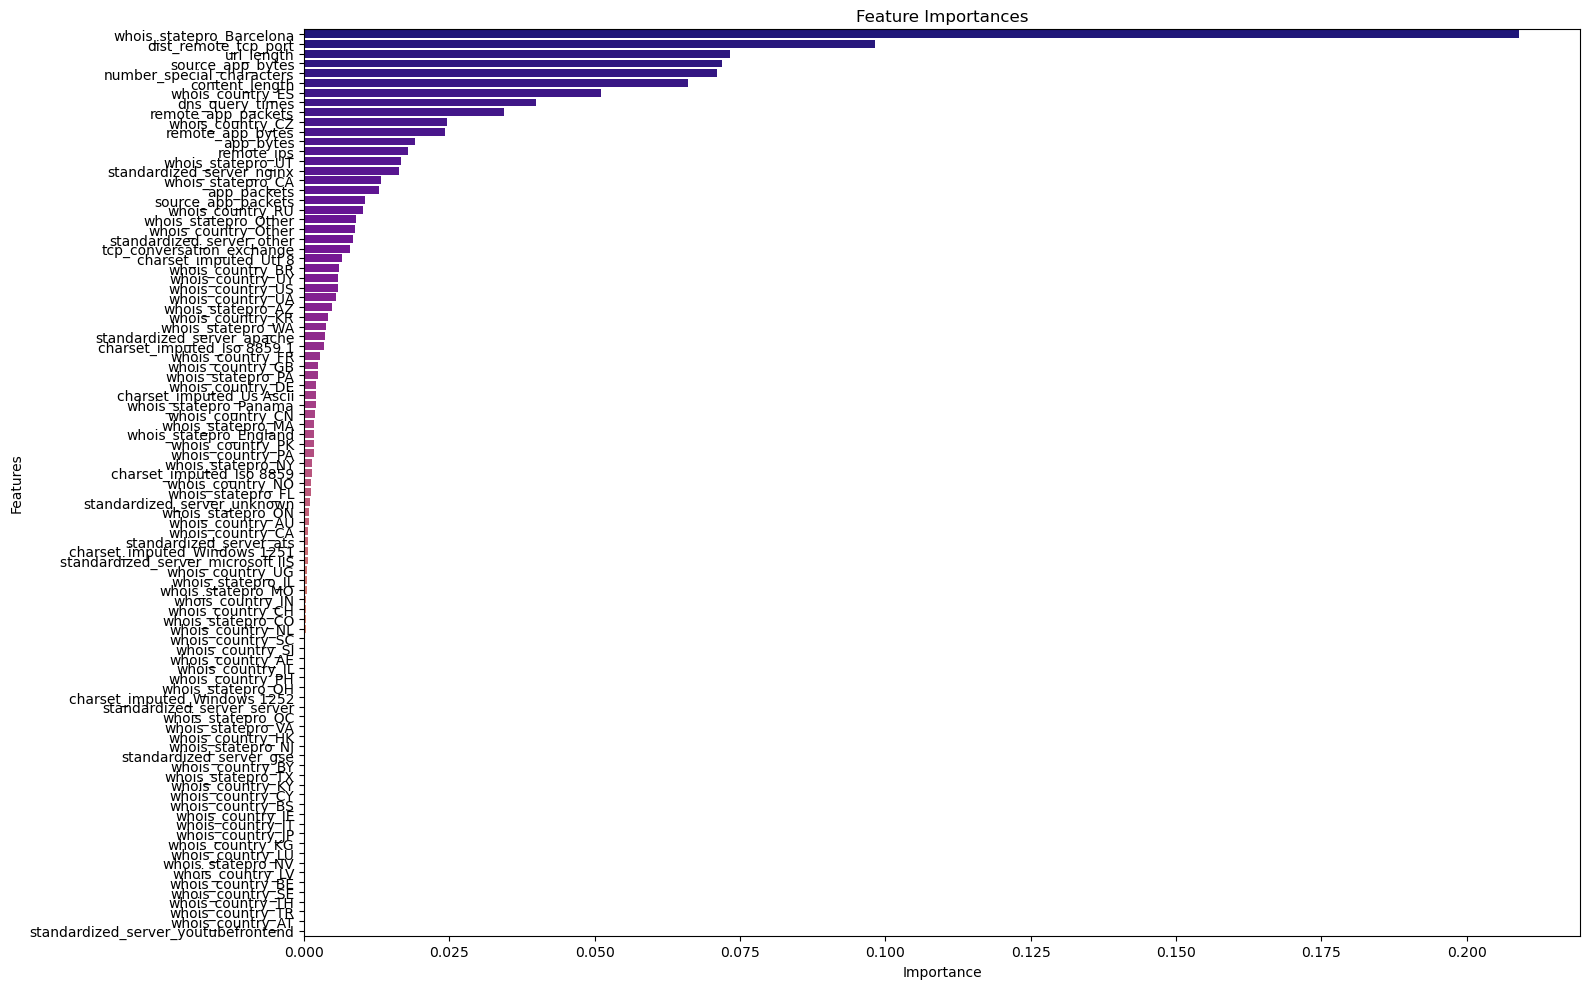

In [71]:
# Use random forest to evaluate feature importance if the dataframe.
model = RandomForestRegressor()
model.fit(preprocess_df.drop(columns=['type']), preprocess_df['type'])

feature_importances = pd.DataFrame(model.feature_importances_,
                                   index=preprocess_df.drop(columns=['type']).columns,
                                   columns=['importance']).sort_values('importance', ascending=False)
# print(feature_importances[:25])

# Plot the feature importances
plt.figure(figsize=(16, 10))
sns.barplot(x=feature_importances['importance'], y=feature_importances.index, palette="plasma")
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

In [119]:
top_15_features = feature_importances.head(15).index.tolist()
top_15_df = preprocess_df[top_15_features + ['type']]

In [120]:
top_15_df 

,whois_statepro_Barcelona,dist_remote_tcp_port,url_length,source_app_bytes,number_special_characters,content_length,whois_country_ES,dns_query_times,remote_app_packets,whois_country_CZ,remote_app_bytes,app_bytes,remote_ips,whois_statepro_UT,standardized_server_nginx,type
0,0.0,0,16,1153,7,263.0,0.0,2,10,0.0,832,700,2,0.0,1.0,1
1,0.0,7,16,1265,6,15087.0,0.0,0,19,0.0,1230,1230,4,0.0,0.0,0
2,0.0,0,16,0,6,324.0,0.0,0,0,0.0,0,0,0,0.0,0.0,0
3,0.0,22,17,18784,6,162.0,0.0,8,37,0.0,4380,3812,3,0.0,1.0,0
4,0.0,2,17,129889,6,124140.0,0.0,4,62,0.0,4586,4278,5,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1776,1.0,0,194,186,16,6897.0,1.0,0,3,0.0,0,0,0,0.0,0.0,1
1777,1.0,0,198,124,17,7900.5,1.0,0,2,0.0,0,0,0,0.0,0.0,1
1778,0.0,2,201,132181,34,8904.0,0.0,4,89,0.0,6945,6631,6,0.0,0.0,0
1779,0.0,0,234,0,34,16669.5,0.0,0,0,0.0,0,0,0,0.0,1.0,0


In [122]:
#Going to create a function for "Shotgun approach" for machine learning modeling.

def classification_model_test(model, X_train, y_train, X_test, y_test):
    # Fit the model with the training data
    model.fit(X_train, y_train)
    
    # Make predictions on the test data
    y_pred = model.predict(X_test)
    
    # Calculate and return the accuracy score
    accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)

    # Generate heatmap of confusion matrix
    sns.heatmap(confusion_matrix(y_true=y_test, y_pred=y_pred),
            annot=True,
            cmap="coolwarm",
            square=True)

    # Print classification report
    print(classification_report(y_true=y_test, y_pred=y_pred))

    return f"Accuracy Score: {accuracy:.2f}"

In [123]:
#Create my target and split the data into X and y to set it up for train test split.
TARGET = ['type']

X, y = top_15_df.drop(columns=TARGET, axis=1), top_15_df[TARGET]

In [124]:
#Setting up training and test data splits for machine learning.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    train_size=0.8,
                                                    test_size=0.2,
                                                    random_state=42
                                                    )


              precision    recall  f1-score   support

           0       0.86      1.00      0.92       306
           1       0.00      0.00      0.00        51

    accuracy                           0.86       357
   macro avg       0.43      0.50      0.46       357
weighted avg       0.73      0.86      0.79       357



'Accuracy Score: 0.86'

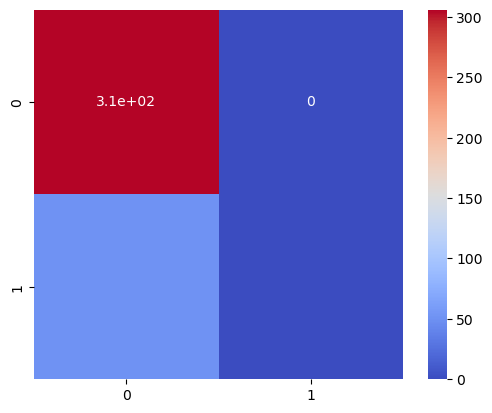

In [125]:
log_reg = LogisticRegression()
classification_model_test(log_reg, X_train, y_train, X_test, y_test)

              precision    recall  f1-score   support

           0       0.89      0.95      0.92       306
           1       0.50      0.31      0.39        51

    accuracy                           0.86       357
   macro avg       0.70      0.63      0.65       357
weighted avg       0.84      0.86      0.84       357



'Accuracy Score: 0.86'

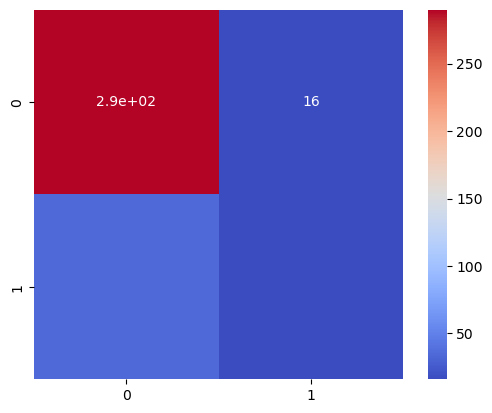

In [126]:
knn_model = KNeighborsClassifier()
classification_model_test(knn_model, X_train, y_train, X_test, y_test)

              precision    recall  f1-score   support

           0       0.95      0.96      0.96       306
           1       0.76      0.73      0.74        51

    accuracy                           0.93       357
   macro avg       0.85      0.84      0.85       357
weighted avg       0.93      0.93      0.93       357



'Accuracy Score: 0.93'

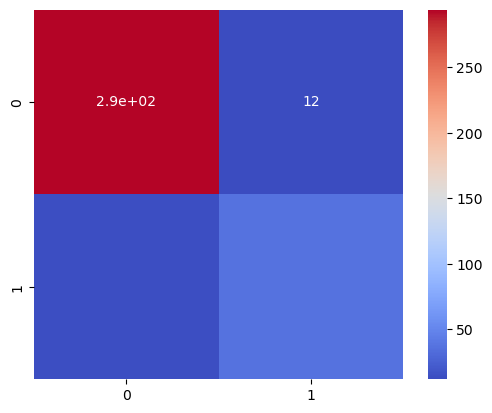

In [127]:
dtc_model = DecisionTreeClassifier()
classification_model_test(dtc_model, X_train, y_train, X_test, y_test)

              precision    recall  f1-score   support

           0       0.86      1.00      0.92       306
           1       0.00      0.00      0.00        51

    accuracy                           0.85       357
   macro avg       0.43      0.50      0.46       357
weighted avg       0.73      0.85      0.79       357



'Accuracy Score: 0.85'

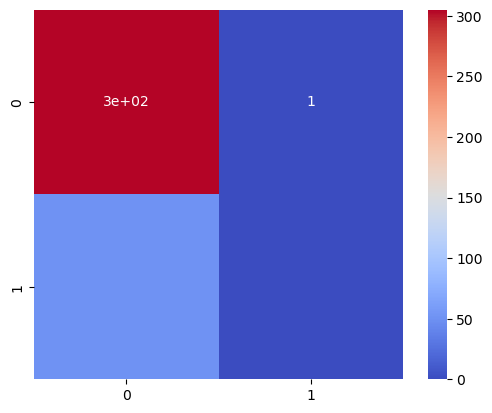

In [129]:
svc_model = SVC()
classification_model_test(svc_model, X_train, y_train, X_test, y_test)

              precision    recall  f1-score   support

           0       0.96      0.99      0.98       306
           1       0.95      0.75      0.84        51

    accuracy                           0.96       357
   macro avg       0.95      0.87      0.91       357
weighted avg       0.96      0.96      0.96       357



'Accuracy Score: 0.96'

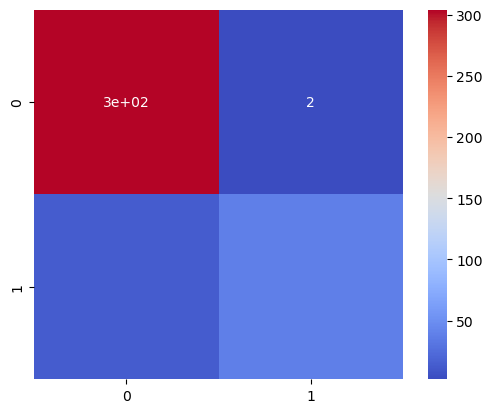

In [130]:
gbc_model = GradientBoostingClassifier()
classification_model_test(gbc_model, X_train, y_train, X_test, y_test)

              precision    recall  f1-score   support

           0       0.96      0.99      0.97       306
           1       0.93      0.73      0.81        51

    accuracy                           0.95       357
   macro avg       0.94      0.86      0.89       357
weighted avg       0.95      0.95      0.95       357



'Accuracy Score: 0.95'

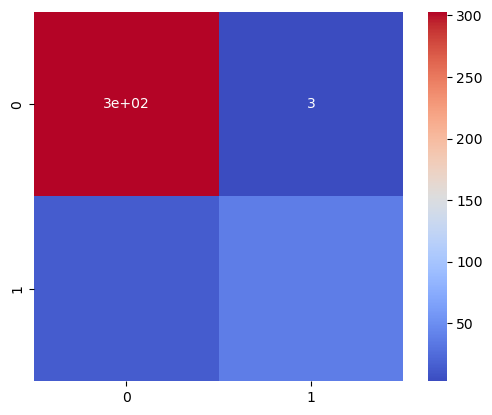

In [131]:
ada_model = AdaBoostClassifier()
classification_model_test(ada_model, X_train, y_train, X_test, y_test)

              precision    recall  f1-score   support

           0       0.95      1.00      0.97       306
           1       1.00      0.67      0.80        51

    accuracy                           0.95       357
   macro avg       0.97      0.83      0.89       357
weighted avg       0.95      0.95      0.95       357



'Accuracy Score: 0.95'

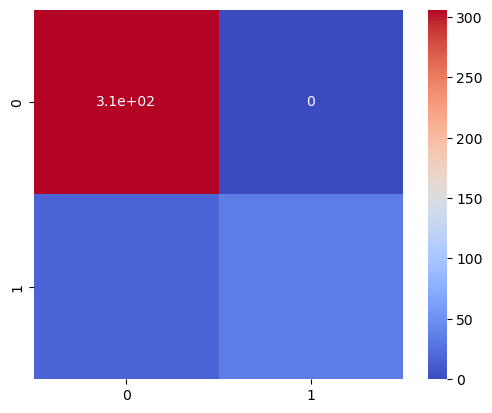

In [132]:
rfc_model = RandomForestClassifier()
classification_model_test(rfc_model, X_train, y_train, X_test, y_test)

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       306
           1       0.97      0.73      0.83        51

    accuracy                           0.96       357
   macro avg       0.96      0.86      0.90       357
weighted avg       0.96      0.96      0.96       357



'Accuracy Score: 0.96'

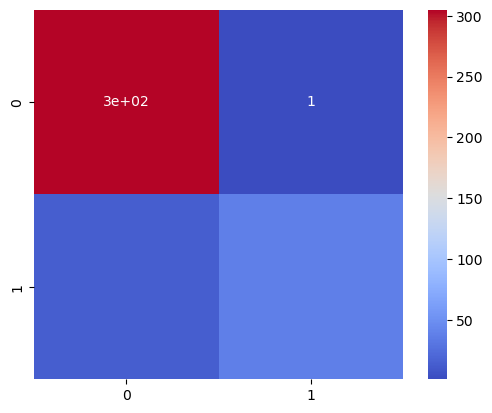

In [133]:
sgd_model = SGDClassifier()
classification_model_test(rfc_model, X_train, y_train, X_test, y_test)

              precision    recall  f1-score   support

           0       0.82      0.42      0.55       306
           1       0.11      0.45      0.18        51

    accuracy                           0.42       357
   macro avg       0.47      0.43      0.37       357
weighted avg       0.72      0.42      0.50       357



'Accuracy Score: 0.42'

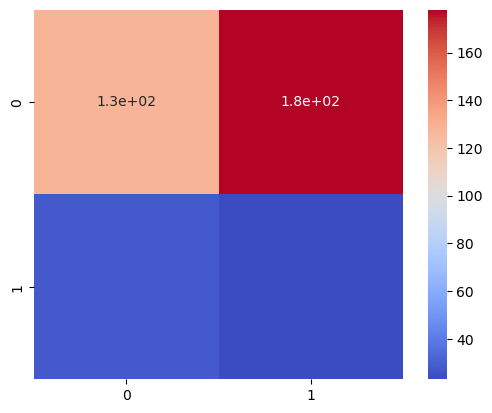

In [134]:
mnb_model = MultinomialNB()
classification_model_test(mnb_model, X_train, y_train, X_test, y_test)